In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import lightgbm as lgb
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
plt.rcParams['font.sans-serif'] = ['KaiTi']
import warnings 
warnings.filterwarnings("ignore")
plt.rcParams['axes.unicode_minus']=False
sales_data = pd.read_parquet('../Data/sales_data.parquet', engine='pyarrow')

## 1. 分布法

    对数转换:
        使用np.log函数对数据进行对数转换。
        创建了一个新列log_transformed来保存对数转换后的值。

    数据可视化:
        使用直方图显示log_transformed列的数据分布。
        使用QQ图检查log_transformed列的数据是否接近正态分布。

    正态性测试:
        进行Shapiro-Wilk测试来检查log_transformed列的数据是否为正态分布。Shapiro-Wilk测试的原假设是数据来自正态分布。

    异常值检测:
        使用Z分数方法来检测异常值。
        计算了每个数据点的Z分数并将其保存在z_score列中。
        使用Z分数的绝对值大于3的标准来确定异常值，并将这些异常值保存在outliers DataFrame中。

    显示异常值:
        使用箱线图显示原始数据的分布，并使用红色点标记异常值。
        显示了移除异常值后的数据分布。

    计算异常值的数量:
        计算并返回异常值的数量。

In [2]:
data = sales_data.copy()
column_to_check = 'total_actual_aftr_comp_profit'

In [3]:
data = data[data[column_to_check] >0]
data_out = sales_data[sales_data[column_to_check] <= 0]
data['log_transformed'] = data[column_to_check].apply(np.log)
q95 = data['log_transformed'].quantile(0.95)
q05 = data['log_transformed'].quantile(0.05)

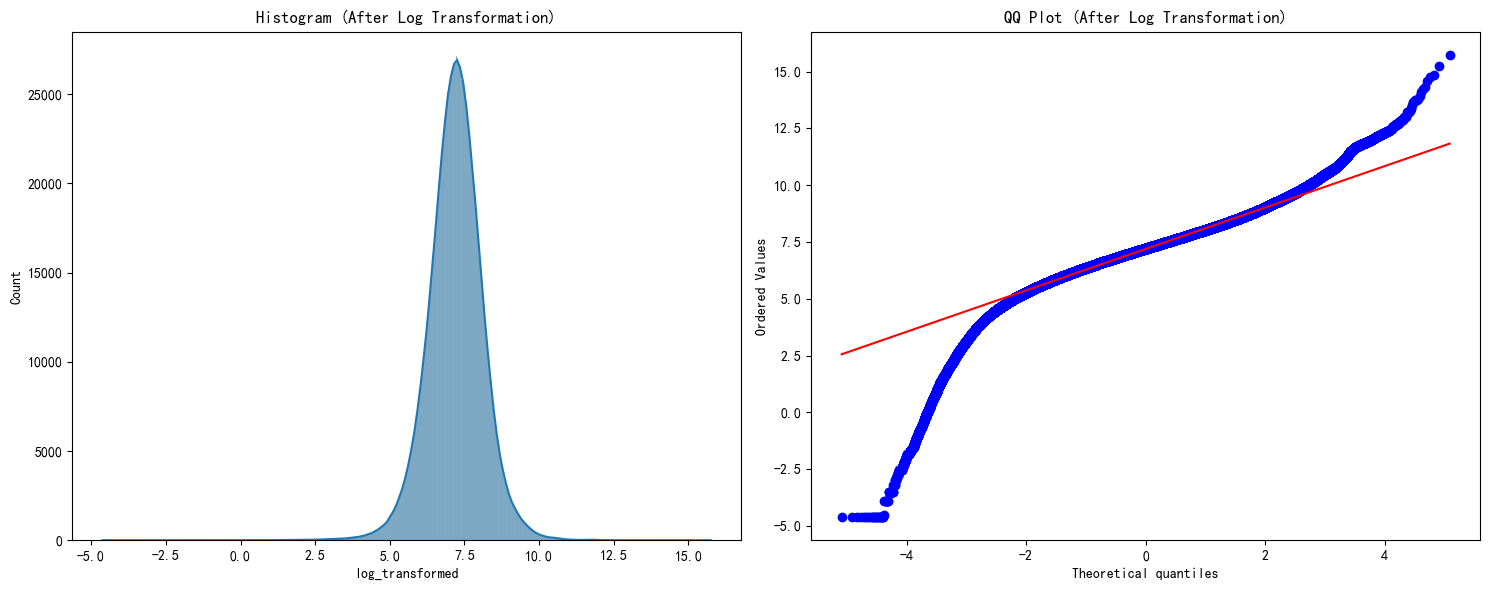

Anderson-Darling Test on Log-transformed Data:
Statistic: 8382.116931742989
Critical Value at 15.0%: 0.576
Critical Value at 10.0%: 0.656
Critical Value at 5.0%: 0.787
Critical Value at 2.5%: 0.918
Critical Value at 1.0%: 1.092




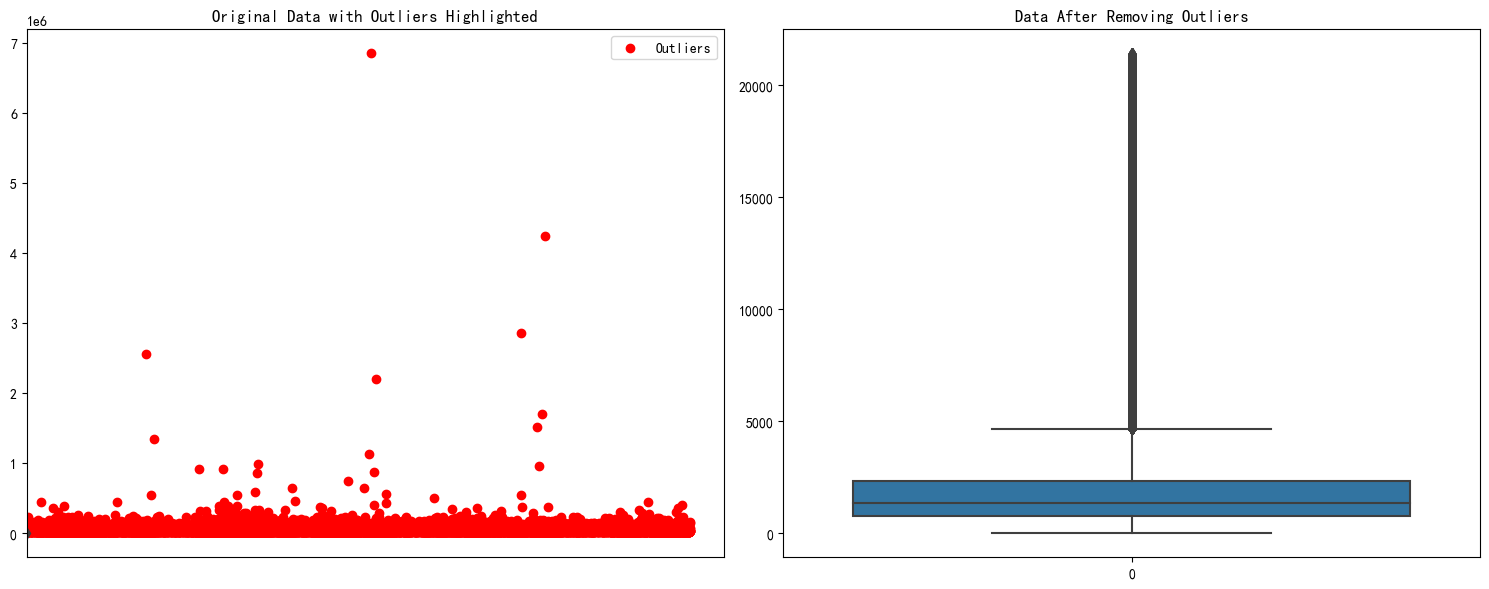

Number of Outliers: 12947


In [4]:
# 数据可视化
plt.figure(figsize=(15, 6))

# 直方图
plt.subplot(1, 2, 1)
sns.histplot(data['log_transformed'], kde=True)
plt.title('Histogram (After Log Transformation)')

# QQ图
plt.subplot(1, 2, 2)
stats.probplot(data['log_transformed'], plot=plt)
plt.title('QQ Plot (After Log Transformation)')

plt.tight_layout()
plt.show()

# 进行Anderson-Darling测试
ad_test_result = stats.anderson(data['log_transformed'], dist='norm')
print("Anderson-Darling Test on Log-transformed Data:\nStatistic:", ad_test_result.statistic)
for i in range(len(ad_test_result.critical_values)):
    sig, crit = ad_test_result.significance_level[i], ad_test_result.critical_values[i]
    print(f"Critical Value at {sig}%:", crit)
print("\n")

# 使用Z分数来检测异常值
data['z_score'] = stats.zscore(data[column_to_check])
outliers_df = data[abs(data['z_score']) > 3]

# 显示异常值
plt.figure(figsize=(15, 6))

# 原始数据
plt.subplot(1, 2, 1)
sns.boxplot(data[column_to_check])
plt.scatter(outliers_df.index, outliers_df[column_to_check], color='red', marker='o', label='Outliers')
plt.title('Original Data with Outliers Highlighted')
plt.legend()

# 去除异常值后的数据
cleaned_data_df = data[abs(data['z_score']) <= 3]
plt.subplot(1, 2, 2)
sns.boxplot(cleaned_data_df[column_to_check])
plt.title('Data After Removing Outliers')

plt.tight_layout()
plt.show()

outliers_count = len(outliers_df)
print("Number of Outliers:", outliers_count)

1. 数据分布不满足正态分布，总体呈现右偏状态
2. 22年12月数据严重影响分布
- 故采用分位数法，理由如下
1. 采用分位数，不受极值影响
2. 不需要样本满足正态分布
3. 计算简单


## 2. 分位数法

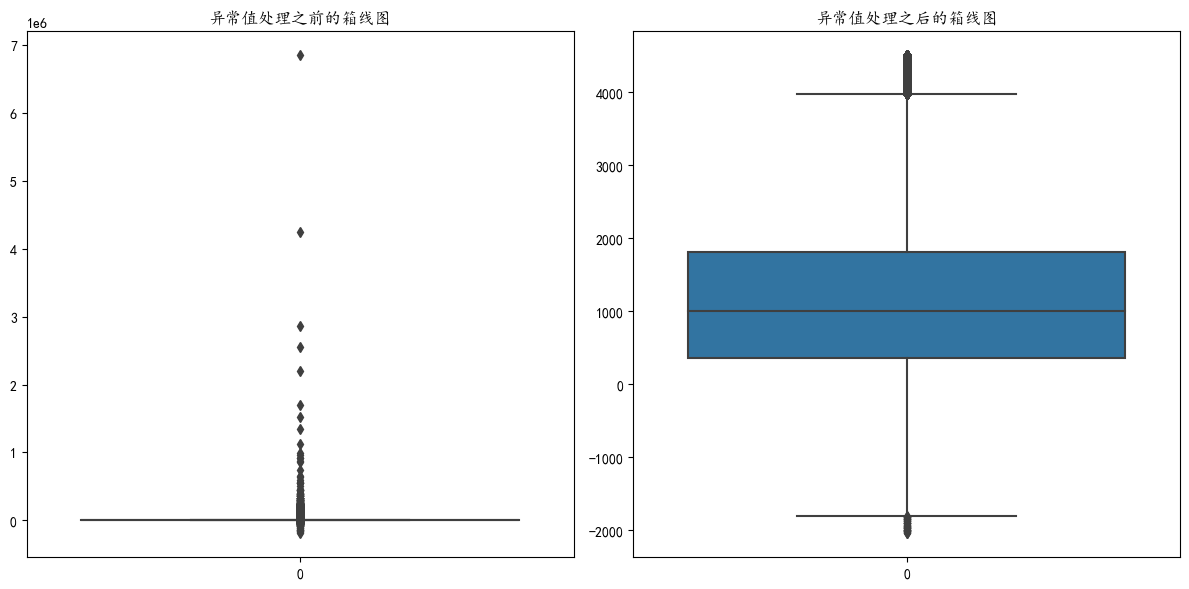

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['KaiTi']
import warnings 
warnings.filterwarnings("ignore")
plt.rcParams['axes.unicode_minus']=False
df = sales_data.copy()

# 计算Q1, Q3和IQR
Q1 = df['total_actual_aftr_comp_profit'].quantile(0.25)
Q3 = df['total_actual_aftr_comp_profit'].quantile(0.75)
IQR = Q3 - Q1

# 定义异常值的标准
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 检测异常值
outliers = df[(df['total_actual_aftr_comp_profit'] < lower_bound) | (df['total_actual_aftr_comp_profit'] > upper_bound)]

# 处理异常值：这里选择删除，但也可以选择替换或其他处理方式
cleaned_df = df[(df['total_actual_aftr_comp_profit'] >= lower_bound) & (df['total_actual_aftr_comp_profit'] <= upper_bound)]

# 可视化
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(df['total_actual_aftr_comp_profit'])
plt.title('异常值处理之前的箱线图')

plt.subplot(1, 2, 2)
sns.boxplot(cleaned_df['total_actual_aftr_comp_profit'])
plt.title('异常值处理之后的箱线图')

plt.tight_layout()
plt.show()

## 3. 基于不同门店的IQR法

In [6]:
df = sales_data[sales_data['total_actual_aftr_comp_profit'] > 0 ].copy()

def detect_outliers(group):
    Q1 = group['total_actual_aftr_comp_profit'].quantile(0.25)
    Q3 = group['total_actual_aftr_comp_profit'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.1 * IQR
    upper_bound = Q3 + 2 * IQR
    mask = (group['total_actual_aftr_comp_profit'] < lower_bound) | (group['total_actual_aftr_comp_profit'] > upper_bound)
    return group[mask]

# 按门店应用异常值检测
outliers = df.groupby('shop_name').apply(detect_outliers).reset_index(drop=True)

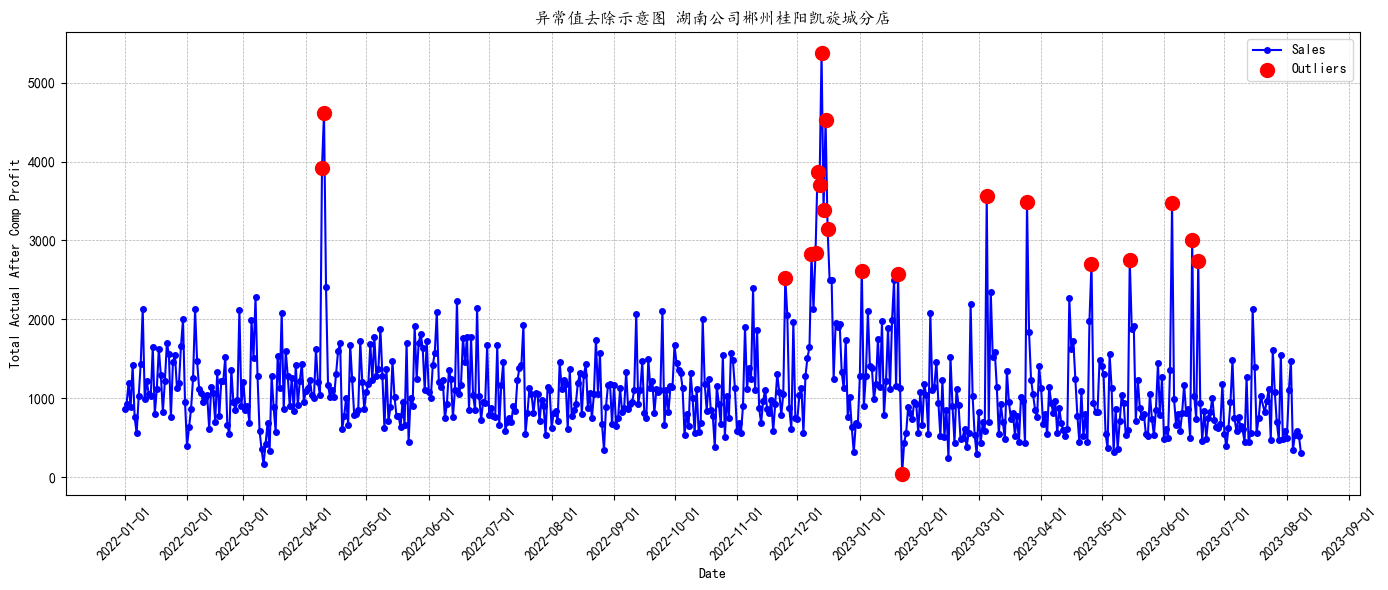

In [7]:
from matplotlib.dates import MonthLocator, DateFormatter
import matplotlib.pyplot as plt

# 确保 billdate 列为 datetime 类型
df['billdate'] = pd.to_datetime(df['billdate'])

# 随机选择一个门店名
selected_shop = np.random.choice(outliers['shop_name'].unique())

# 获取该门店的数据并按日期排序
shop_data = df[df['shop_name'] == selected_shop].sort_values(by="billdate")

# 获取该门店的异常点数据并按日期排序
shop_outliers = outliers[outliers['shop_name'] == selected_shop].sort_values(by="billdate")

# 绘制折线图
plt.figure(figsize=(14, 6))
plt.plot(shop_data['billdate'], shop_data['total_actual_aftr_comp_profit'], label='Sales', marker='o', markersize=4, linestyle='-', color='blue')
plt.scatter(shop_outliers['billdate'], shop_outliers['total_actual_aftr_comp_profit'], color='red', s=100, zorder=5, label='Outliers')

# 设置 x 轴上的日期标签
ax = plt.gca()
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45)

plt.title(f"异常值去除示意图 {selected_shop}")
plt.xlabel("Date")
plt.ylabel("Total Actual After Comp Profit")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()